In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv =ArxivQueryRun(api_wrapper=api_wapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [5]:
api_wapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke("What is meachine learning?")

'No good Wikipedia Search Result was found'

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()



C:\Users\PC\AppData\Local\Temp\ipykernel_18232\883015683.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Daily News March 03 2025: 🚀 Nvidia CEO',
  'url': 'https://podcasts.apple.com/ca/podcast/ai-daily-news-march-03-2025-nvidia-ceo-us-ai-chips/id1684415169?i=1000697521476',
  'content': "Nvidia claims a significant lead in AI chip speed over China, while Apple faces delays in its Siri AI overhaul. New AI applications are emerging, including highly realistic voice generation, automated resume screening, and AI cardiologists in China.OpenAI plans to integrate Sora video AI into ChatGPT, and large investments are being made in AI by companies like Honor and SoftBank. AI is also showing promise in healthcare with tools for cancer detection and improved patient care, but concerns exist about algorithmic bias and the financial sustainability of some AI models. Finally, AI is anticipated to surpass human coding abilities, with models like Claude being evaluated for scientific and national security purposes and Samsung launching AI-powered devices to rival Apple. [...] AI Unravele

In [9]:
tools = [arxiv,wiki,tavily]

In [10]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile")

llm_with_tools = llm.bind_tools(tools)

e:\ONEXT\AI Research\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '6stzbdfhc',
  'type': 'tool_call'}]

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages :Annotated[
        list[AnyMessage],
        add_messages  
    ]

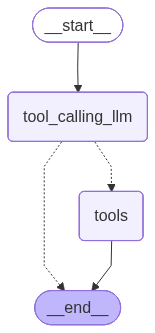

In [22]:
from IPython.display import display, JSON, Image
from langgraph.graph import END, StateGraph,START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}



builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))